In [12]:
!pip install -q torch opencv-python pandas
!pip install -q ultralytics matplotlib
!pip install -q huggingface_hub gdown
!pip install -q deep-sort-realtime torchreid motmetrics

# Kaggle

In [2]:
import kagglehub

root_path = "/kaggle/working"

dataset_path = kagglehub.dataset_download("ayushspai/sportsmot")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/sportsmot


# Colab

In [3]:
# !pip install -q kaggle
# !kaggle datasets download -d ayushspai/sportsmot -q
# !unzip -q sportsmot.zip -d SportsMOT
# !rm sportsmot.zip
# !mv /content/SportsMOT/sportsmot_publish/dataset/val/* /content/SportsMOT/sportsmot_publish/dataset/train > /dev/null 2>&1

In [14]:
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ultralytics import YOLO

import shutil

from huggingface_hub import HfApi, Repository, hf_hub_download

from deep_sort_realtime.deepsort_tracker import DeepSort

import motmetrics as mm
from collections import deque
from scipy.optimize import linear_sum_assignment

import gdown

In [5]:
yolo_dataset_path = "/kaggle/working/dataset"
model_path = "/kaggle/working/runs/detect/yolov8_football/weights/best.pt"
test_image_path = "/kaggle/working/sportsmot/test/v_-hhDbvY5aAM_c001/img1/000001.jpg"
test_sequence_path = "/kaggle/working/sportsmot/test/v_-hhDbvY5aAM_c001/img1"
val_sequence_path = "/kaggle/working/sportsmot/val/v_2QhNRucNC7E_c017/img1"
val_label_path = "/kaggle/working/sportsmot/val/v_2QhNRucNC7E_c017/gt/gt.txt"
validation_path = "/kaggle/working/sportsmot/val"
output_path = "results"

# Dataset

In [6]:
def load_football_sequences(splits_path):
    football_file = os.path.join(splits_path, "football.txt")
    with open(football_file, "r") as f:
        football_sequences = f.read().splitlines()
    return set(football_sequences)

def copy_football_data(root_path, dataset_path):
    destination_path = os.path.join(root_path, "sportsmot")
    if os.path.exists(destination_path):
        print("Football data already exists!")
        return destination_path
    os.makedirs(destination_path, exist_ok=True)
    
    splits_path = os.path.join(dataset_path, "sportsmot_publish", "splits_txt")
    football_sequences = load_football_sequences(splits_path)
    shutil.copytree(splits_path, os.path.join(destination_path, "splits_txt"), dirs_exist_ok=True)
    
    for split in ["train", "val", "test"]:
        split_path = os.path.join(dataset_path, "sportsmot_publish", "dataset", split)
        dest_split_path = os.path.join(destination_path, split)
        os.makedirs(dest_split_path, exist_ok=True)
        
        if not os.path.exists(split_path):
            continue

        sequences = os.listdir(split_path)
        for seq in sequences:
            seq_path = os.path.join(split_path, seq)
            dest_seq_path = os.path.join(dest_split_path, seq)
            
            if seq in football_sequences:
                shutil.copytree(seq_path, dest_seq_path, dirs_exist_ok=True)

    print("Football data copying complete!")
    return destination_path

dataset_path = copy_football_data(root_path, dataset_path)
print("Path to dataset files:", dataset_path)

Football data already exists!
Path to dataset files: /kaggle/working/sportsmot


# Object Detection

## Converting Dataset

In [10]:
def convert_to_yolo_format(root_path, dataset_path, split):
    if os.path.exists(os.path.join(root_path, "dataset")):
        print("dataset already exists!")
        return
        
    os.makedirs(os.path.join(root_path, "dataset", "images", split), exist_ok=True)
    os.makedirs(os.path.join(root_path, "dataset", "labels", split), exist_ok=True)

    splits_path = os.path.join(dataset_path, "splits_txt")
    football_sequences = load_football_sequences(splits_path)

    for seq in football_sequences:
        seq_path = os.path.join(dataset_path, split, seq)
        gt_file = os.path.join(seq_path, "gt", "gt.txt")

        if not os.path.exists(gt_file):
            continue

        df = pd.read_csv(gt_file, header=None)
        df.columns = [
            "frame_id", "object_id", "x", "y", "w", "h",
            "conf", "class_id", "visibility"
        ]

        for frame_id, group in df.groupby("frame_id"):
            img_path = os.path.join(seq_path, "img1", f"{frame_id:06d}.jpg")
            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            img_name = f"{seq}_{frame_id:06d}.jpg"
            cv2.imwrite(os.path.join(root_path, "dataset", "images", split, img_name), img)

            label_file = os.path.join(root_path, "dataset", "labels", split, f"{seq}_{frame_id:06d}.txt")
            with open(label_file, "w") as f:
                for _, row in group.iterrows():
                    x_center = (row["x"] + row["w"] / 2) / img.shape[1]
                    y_center = (row["y"] + row["h"] / 2) / img.shape[0]
                    width = row["w"] / img.shape[1]
                    height = row["h"] / img.shape[0]
                    f.write(f"{int(row['class_id'])} {x_center} {y_center} {width} {height}\n")

convert_to_yolo_format(root_path, dataset_path, "train")
convert_to_yolo_format(root_path, dataset_path, "val")
convert_to_yolo_format(root_path, dataset_path, "test")

dataset already exists!
dataset already exists!
dataset already exists!


## YOLO

Why We Chose YOLO for the Detection Task


1. Real-Time Performance
YOLO is designed for real-time object detection with high frame rates.
Unlike two-stage detectors (e.g., Faster R-CNN), YOLO processes an entire image in a single forward pass, making it significantly faster.
Speed matters in tracking applications, where detection must keep up with high FPS video streams.

2. High Detection Accuracy
YOLOv8, the latest version, achieves high accuracy while maintaining speed.
It effectively detects small objects and multiple objects in a crowded scene, which is essential for tracking players in sports videos.
It is trained on large-scale datasets like COCO and can be fine-tuned on our specific dataset (e.g., football players).

### yaml

In [11]:
def create_yaml_file(dataset_path, class_names):
    yaml_content = f"""
path: {dataset_path}
train: images/train
val: images/val
test: images/test

nc: {len(class_names)}
names: {class_names}
"""
    yaml_path = os.path.join(dataset_path, "dataset.yaml")
    if os.path.exists(yaml_path):
        print("YAML file already exists!")
        return
    with open(yaml_path, "w") as f:
        f.write(yaml_content)

    print(f"YAML file created at: {yaml_path}")

class_names = ['ball', 'player', 'referee', 'other']

create_yaml_file(yolo_dataset_path, class_names)

YAML file already exists!


## Base YOLO


image 1/1 /kaggle/working/sportsmot/test/v_-hhDbvY5aAM_c001/img1/000001.jpg: 384x640 8 persons, 1 sports ball, 51.5ms
Speed: 4.9ms preprocess, 51.5ms inference, 169.5ms postprocess per image at shape (1, 3, 384, 640)


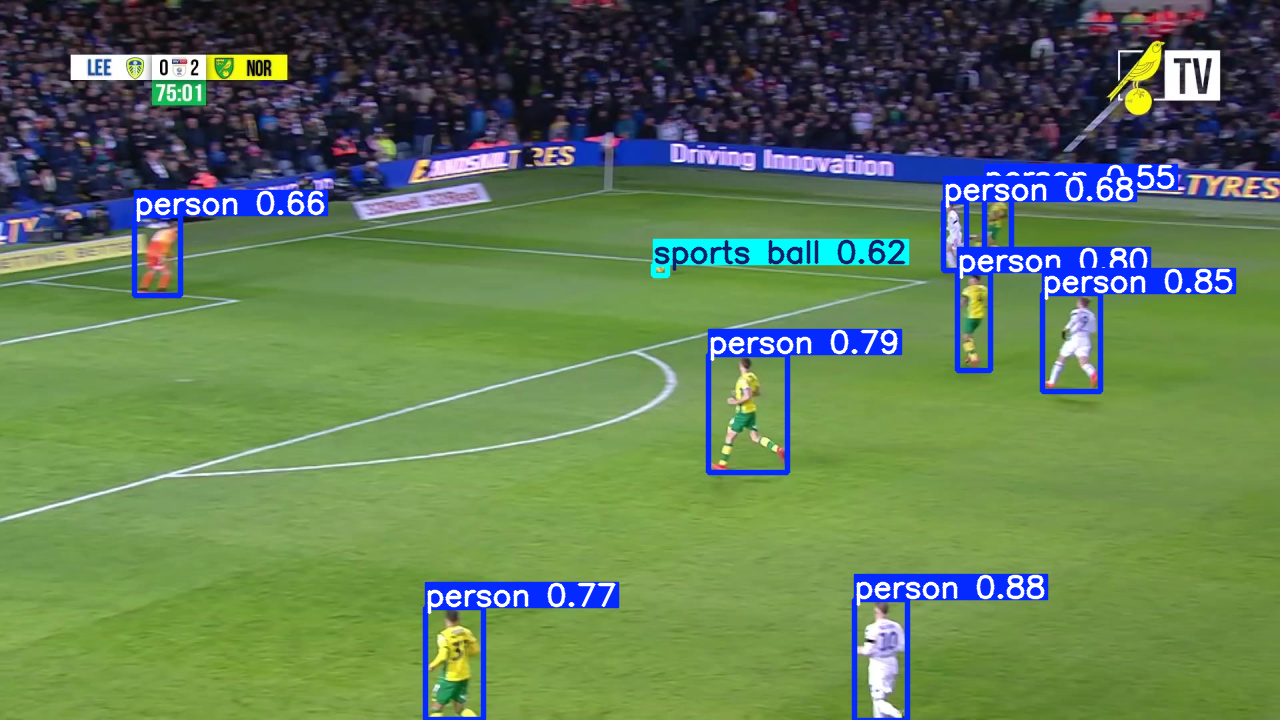

In [12]:
model = YOLO("yolov8n.pt")

results = model(test_image_path)

for result in results:
    result.show()

## Train

In [ ]:
results = model.train(
    data=f"{yolo_dataset_path}/dataset.yaml",
    epochs=30,
    imgsz=1280,
    batch=16,
    patience=10,
    augment=True,
    mixup=0.2,
    name="yolov8_football",
    resume=False,
    exist_ok=True,
    verbose=False,
)

Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_football, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /kaggle/working/dataset/labels/train.cache... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/dataset/labels/val.cache... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000500.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /ka

Plotting labels to runs/detect/yolov8_football/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_football
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      16.1G      1.078     0.9888      1.023        172       1280: 100%|██████████| 695/695 [08:22<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:26<00:00,  3.27it/s]


                   all       9058     117024      0.895      0.939      0.951      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      14.5G     0.7891     0.5041     0.8928        330       1280: 100%|██████████| 695/695 [07:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:24<00:00,  3.37it/s]


                   all       9058     117024       0.91      0.953      0.948      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      14.5G      0.737      0.436     0.8771        295       1280: 100%|██████████| 695/695 [07:12<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:23<00:00,  3.39it/s]


                   all       9058     117024      0.919       0.95      0.956      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      15.4G     0.7084     0.4062     0.8685        186       1280: 100%|██████████| 695/695 [07:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:23<00:00,  3.39it/s]


                   all       9058     117024      0.923      0.952      0.957      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      11.8G     0.6893      0.388     0.8625        319       1280: 100%|██████████| 695/695 [07:10<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:21<00:00,  3.47it/s]


                   all       9058     117024      0.913       0.96      0.936      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.3G     0.6746     0.3756      0.859        196       1280: 100%|██████████| 695/695 [07:10<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:23<00:00,  3.40it/s]


                   all       9058     117024      0.927      0.952      0.954      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      16.1G     0.6612     0.3655     0.8555        357       1280: 100%|██████████| 695/695 [07:10<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:22<00:00,  3.45it/s]


                   all       9058     117024      0.934      0.958      0.966      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.8G     0.6553     0.3599     0.8536        562       1280:  70%|██████▉   | 486/695 [05:02<02:10,  1.60it/s]

### Logs

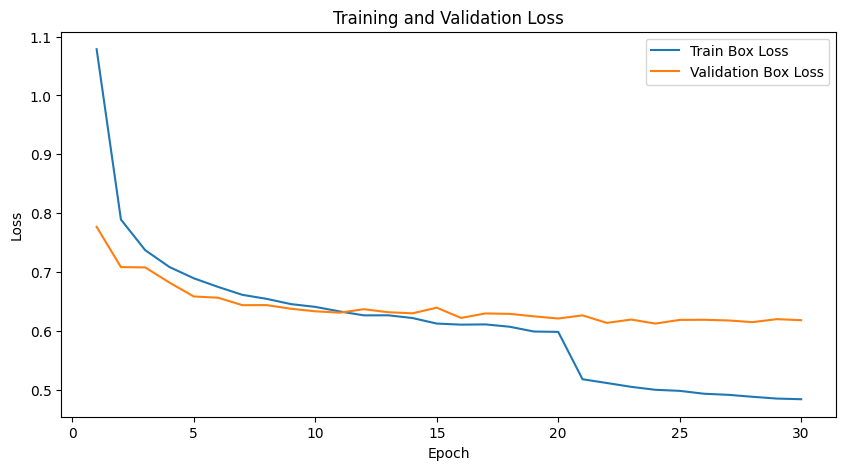

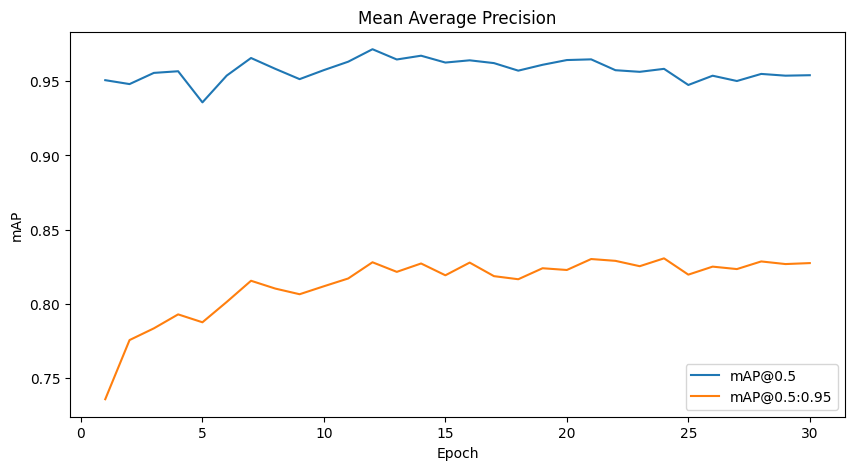

In [4]:
def plot_logs(results_path):
    logs = pd.read_csv(results_path)

    plt.figure(figsize=(10, 5))
    plt.plot(logs["epoch"], logs["train/box_loss"], label="Train Box Loss")
    plt.plot(logs["epoch"], logs["val/box_loss"], label="Validation Box Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(logs["epoch"], logs["metrics/mAP50(B)"], label="mAP@0.5")
    plt.plot(logs["epoch"], logs["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("Mean Average Precision")
    plt.legend()
    plt.show()

results_path = "/kaggle/working/runs/detect/yolov8_football/results.csv"
plot_logs(results_path)

### Testing and Validation


image 1/1 /kaggle/working/sportsmot/test/v_-hhDbvY5aAM_c001/img1/000001.jpg: 736x1280 8 players, 36.2ms
Speed: 15.6ms preprocess, 36.2ms inference, 286.2ms postprocess per image at shape (1, 3, 736, 1280)


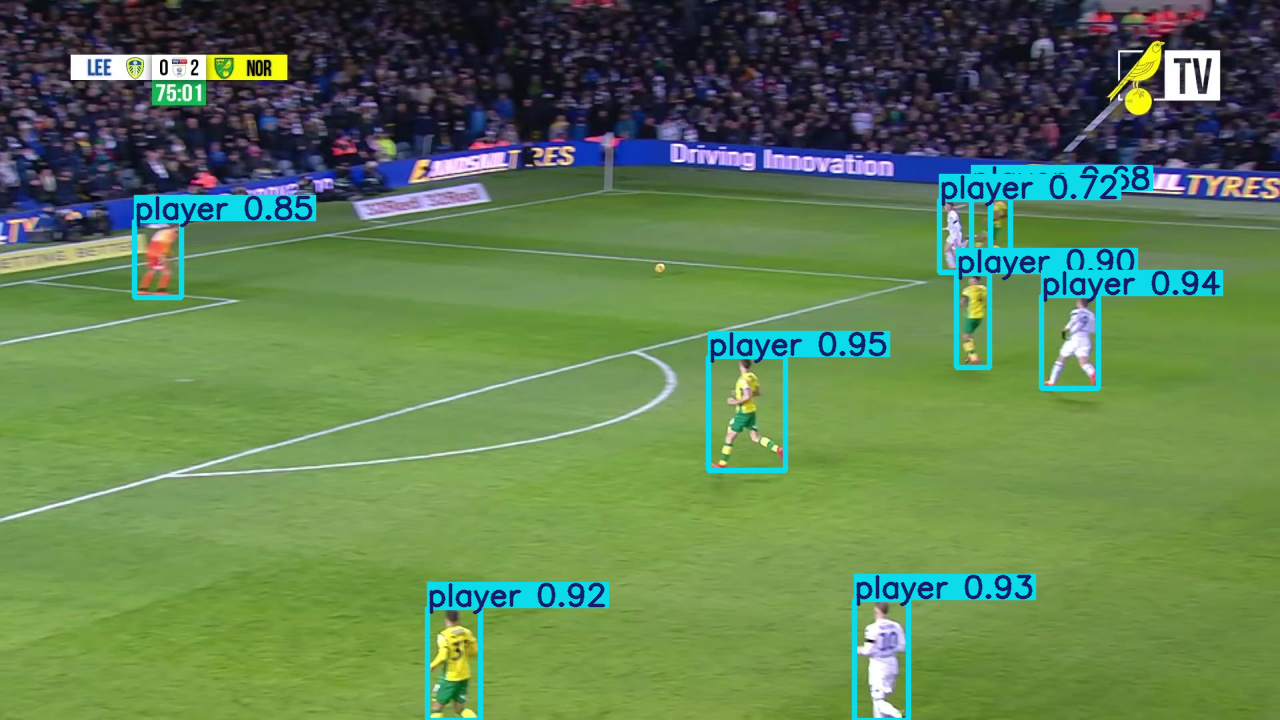

In [5]:
model = YOLO(model_path)

results = model(test_image_path)

for result in results:
    result.show()

In [6]:
metrics = model.val()

print(f"mAP@0.5: {metrics.results_dict['metrics/mAP50(B)']}")
print(f"mAP@0.5:0.95: {metrics.results_dict['metrics/mAP50-95(B)']}")

Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]
val: Scanning /kaggle/working/dataset/labels/val.cache... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/dataset/images/val/v_i2_L4qquVg0_c006_000500.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /ka


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 567/567 [01:51<00:00,  5.07it/s]


                   all       9058     117024      0.938      0.954      0.965      0.832
                player       9058     117024      0.938      0.954      0.965      0.832


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 4.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val2
mAP@0.5: 0.9648428241060886
mAP@0.5:0.95: 0.8319424697819564


# Saving to Hugging Face


In [6]:
hf_token = None
model_path = "/kaggle/working/runs/detect/yolov8_football/weights/best.pt"
repo_id = "ParsaGh/yolov8_football"

In [8]:
if hf_token:
    api = HfApi()
    api.create_repo(repo_id, exist_ok=True, token=hf_token)
    
    api.upload_file(
        path_or_fileobj=model_path,
        path_in_repo="best.pt",
        repo_id=repo_id,
        token=hf_token
    )
    
    print("Model successfully uploaded to Hugging Face Hub!")

No files have been modified since last commit. Skipping to prevent empty commit.


Model successfully uploaded to Hugging Face Hub!


# Loading From Hugging Face

In [7]:
if hf_token:
    model_path = hf_hub_download(
        repo_id=repo_id,
        filename="best.pt",
        use_auth_token=hf_token
    )
    
    print(model_path)
    model = YOLO(model_path)
    
    results = model(test_image_path)
    for result in results:
        result.show()

best.pt:   0%|          | 0.00/6.31M [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--ParsaGh--yolov8_football/snapshots/a72554a4a76d5b47af19ad49c34cda4df8cff3d2/best.pt


NameError: name 'test_image_path' is not defined

# Utility

In [25]:
def compute_iou(boxA, boxB):
    xA, yA, wA, hA = boxA
    xA2, yA2 = xA + wA, yA + hA

    xB, yB, wB, hB = boxB
    xB2, yB2 = xB + wB, yB + hB

    inter_x1 = max(xA, xB)
    inter_y1 = max(yA, yB)
    inter_x2 = min(xA2, xB2)
    inter_y2 = min(yA2, yB2)

    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    areaA = wA * hA
    areaB = wB * hB

    union_area = areaA + areaB - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def parse_multi_object_ground_truth(gt_file):
    gt_dict = {}
    with open(gt_file, 'r') as f:
        for line in f:
            parts = [p.strip() for p in line.strip().split(',')]
            if len(parts) < 6:
                continue
            try:
                frame = int(parts[0])
                obj_id = int(parts[1])
                x = float(parts[2])
                y = float(parts[3])
                w = float(parts[4])
                h = float(parts[5])
                if frame not in gt_dict:
                    gt_dict[frame] = []
                gt_dict[frame].append((obj_id, (x, y, w, h)))
            except ValueError:
                continue
    return gt_dict

def parse_all_ground_truth(gt_file):
    gt_dict = {}
    with open(gt_file, 'r') as f:
        for line in f:
            parts = [p.strip() for p in line.strip().split(',')]
            if len(parts) < 6:
                continue
            try:
                frame_num = int(parts[0])
                obj_id = int(parts[1])
                x = int(float(parts[2]))
                y = int(float(parts[3]))
                w = int(float(parts[4]))
                h = int(float(parts[5]))
                if frame_num not in gt_dict:
                    gt_dict[frame_num] = []
                gt_dict[frame_num].append((obj_id, (x, y, w, h)))
            except ValueError:
                continue
    return gt_dict


def evaluate_multi_object_tracking(predictions, ground_truth, iou_threshold=0.5):
    gt_df = pd.DataFrame(ground_truth, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    pred_df = pd.DataFrame(predictions, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    
    acc = mm.MOTAccumulator(auto_id=True)
    
    frames = sorted(set(gt_df['Frame'].unique()).union(set(pred_df['Frame'].unique())))
    
    for frame in frames:
        gt_frame = gt_df[gt_df['Frame'] == frame]
        pred_frame = pred_df[pred_df['Frame'] == frame]
        
        gt_ids = gt_frame['Id'].tolist()
        pred_ids = pred_frame['Id'].tolist()
        
        gt_boxes = gt_frame[['X', 'Y', 'W', 'H']].to_numpy()
        pred_boxes = pred_frame[['X', 'Y', 'W', 'H']].to_numpy()
        
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            acc.update([], [], np.empty((0, 0)))
        elif len(gt_boxes) == 0:
            acc.update([], pred_ids, np.empty((0, len(pred_ids))))
        elif len(pred_boxes) == 0:
            acc.update(gt_ids, [], np.empty((len(gt_ids), 0)))
        else:
            cost_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
            for i, gt_box in enumerate(gt_boxes):
                for j, pred_box in enumerate(pred_boxes):
                    iou = compute_iou(gt_box, pred_box)
                    cost_matrix[i, j] = 1 - iou
            acc.update(gt_ids, pred_ids, cost_matrix)
    
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota', 'idf1', 'precision'], name='acc')
    print("MOT Metrics Summary:")
    print(summary)
    return summary

def evaluate_mot_performance(predictions, ground_truth, iou_threshold=0.5):
    acc = mm.MOTAccumulator(auto_id=True)
    
    pred_df = pd.DataFrame(predictions, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    gt_df = pd.DataFrame(ground_truth, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    
    for frame in sorted(set(pred_df.Frame.unique()).union(gt_df.Frame.unique())):
        frame_preds = pred_df[pred_df.Frame == frame]
        frame_gt = gt_df[gt_df.Frame == frame]
        
        gt_boxes = frame_gt[['X', 'Y', 'W', 'H']].values
        pred_boxes = frame_preds[['X', 'Y', 'W', 'H']].values
        gt_ids = frame_gt.Id.values
        pred_ids = frame_preds.Id.values
        
        cost = np.zeros((len(gt_boxes), len(pred_boxes)))
        for i, gt_box in enumerate(gt_boxes):
            for j, pred_box in enumerate(pred_boxes):
                cost[i, j] = 1 - compute_iou(gt_box, pred_box)
        
        acc.update(gt_ids, pred_ids, cost)
    
    metrics = mm.metrics.create().compute(acc, 
        metrics=['mota', 'idf1', 'precision', 'recall', 'mostly_tracked', 
                'mostly_lost', 'num_false_positives', 'num_misses', 
                'num_switches', 'num_fragmentations'],
        name='FairMOT')
    
    print(mm.io.render_summary(metrics, formatters=mm.metrics.create().formatters))
    return metrics

def download_video(video_url, output_file="input_video.mp4"):
    print(f"Downloading video from {video_url} to {output_file}...")
    gdown.download(url=video_url, output=output_file, quiet=False, fuzzy=True)
    return output_file

def extract_frames(video_path, frames_dir="video_frames"):
    print(f"Extracting frames from {video_path} into directory {frames_dir}...")
    if os.path.exists(frames_dir):
        print("Frames already exists!")
        return frames_dir
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()
    while success:
        frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1
        success, frame = cap.read()
    cap.release()
    print(f"Extracted {frame_count} frames.")
    return frames_dir

# Single Object Tracking

High Accuracy & Robustness

The CSRT tracker uses discriminative correlation filters with channel and spatial reliability maps, allowing it to:
Track objects with occlusions and motion blur better than traditional correlation-based trackers.
Maintain high accuracy even with scale variations (e.g., a player moving closer or further in a sports match).
Adapt to appearance changes, making it more reliable for real-world tracking.

## SOT Tracker

In [7]:
class SingleObjectTracker:
    def __init__(self, yolo_model, target_class=1, conf_threshold=0.5):
        self.yolo = yolo_model
        self.tracker = cv2.TrackerCSRT_create()
        self.target_class = target_class
        self.conf_threshold = conf_threshold
        self.last_valid_bbox = None
        self.heatmap = None
        self.heatmap_alpha = 0.5
        self.initialized = False

    def track(self, frame):
        if not self.initialized:
            success, bbox = self._reinitialize_tracker(frame)
            self.initialized = True
        else:
            success, bbox = self.tracker.update(frame)
        
        if not success or self._needs_reinitialization(bbox, frame):
            print("Reinitializing tracker...")
            success, bbox = self._reinitialize_tracker(frame)
        
        if success:
            self.last_valid_bbox = bbox
        
        return success, bbox

    def _needs_reinitialization(self, bbox, frame):
        if bbox is None:
            return True
        
        x, y, w, h = bbox
        if w <= 0 or h <= 0:
            return True
        
        if self.last_valid_bbox is not None:
            last_x, last_y, last_w, last_h = self.last_valid_bbox
            cx, cy = x + w / 2, y + h / 2
            last_cx, last_cy = last_x + last_w / 2, last_y + last_h / 2
            
            frame_height, frame_width = frame.shape[:2]
            dx = abs(cx - last_cx) / frame_width
            dy = abs(cy - last_cy) / frame_height
            if dx > 0.5 or dy > 0.5:
                return True
        return False

    def _reinitialize_tracker(self, frame):
        results = self.yolo(frame, verbose=False)[0]
        detections = []
        
        for box, cls, conf in zip(results.boxes.xywh, results.boxes.cls, results.boxes.conf):
            cls_int = int(cls.item())
            conf_val = float(conf.item())
            
            if cls_int == self.target_class and conf_val >= self.conf_threshold:
                box_np = box.cpu().numpy()
                x_center, y_center, w, h = box_np
                x1 = x_center - w / 2
                y1 = y_center - h / 2
                detections.append((conf_val, (int(x1), int(y1), int(w), int(h))))
        
        if detections:
            best_conf, best_bbox = max(detections, key=lambda d: d[0])
            self.tracker = cv2.TrackerCSRT_create()
            self.tracker.init(frame, best_bbox)
            return True, best_bbox
        else:
            return False, None

    def update_heatmap(self, bbox, frame_shape):
        if bbox is None:
            return
        
        if self.heatmap is None:
            self.heatmap = np.zeros(frame_shape, dtype=np.float32)
        
        x, y, w, h = bbox
        center_x = int(x + w / 2)
        center_y = int(y + h / 2)
        cv2.circle(self.heatmap, (center_x, center_y), 10, 1, -1)
        self.heatmap = cv2.GaussianBlur(self.heatmap, (51, 51), 0)

    def draw_heatmap(self, frame):
        if self.heatmap is None:
            return frame
        
        heatmap_norm = cv2.normalize(self.heatmap, None, 0, 255, cv2.NORM_MINMAX)
        heatmap_norm = heatmap_norm.astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(frame, 1 - self.heatmap_alpha, heatmap_colored, self.heatmap_alpha, 0)
        return overlay

## SOT Test

In [11]:
def test_single_object_tracker(frames_path, yolo_model, output_path="results", conf_threshold=0.5):
    tracker = SingleObjectTracker(yolo_model,
                                  target_class=1,
                                  conf_threshold=conf_threshold)
    
    os.makedirs(output_path, exist_ok=True)
    frame_files = sorted([
        os.path.join(frames_path, f)
        for f in os.listdir(frames_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    if not frame_files:
        raise ValueError("No frames found in the provided directory.")
    
    first_frame = cv2.imread(frame_files[0])
    if first_frame is None:
        raise ValueError("Unable to read the first frame.")
    height, width = first_frame.shape[:2]
    
    video_out_path = os.path.join(output_path, "sot_tracking_result.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 25
    out_video = cv2.VideoWriter(video_out_path, fourcc, fps, (width, height))
    
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            continue
        
        success, bbox = tracker.track(frame)
        
        tracker.update_heatmap(bbox, frame_shape=(height, width))
        frame_with_heatmap = tracker.draw_heatmap(frame)
        
        if bbox is not None:
            x, y, w, h = bbox
            cv2.rectangle(frame_with_heatmap, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        out_video.write(frame_with_heatmap)
    
    out_video.release()
    print(f"Results saved to: {os.path.abspath(video_out_path)}")

In [12]:
conf_threshold = 0.5    
test_single_object_tracker(test_sequence_path, model, output_path, conf_threshold)

Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Results saved to: /kaggle/working/results/sot_tracking_result.mp4


## SOT Validation

In [16]:
def evaluate_tracker_on_sequence(seq_path, yolo_model, conf_threshold=0.5,
                                 iou_threshold=0.5, output_dir="results"):
    gt_file = os.path.join(seq_path, "gt", "gt.txt")
    if not os.path.exists(gt_file):
        print(f"Ground truth file not found in {seq_path}")
        return None
    gt_all = parse_all_ground_truth(gt_file)
    
    img_folder = os.path.join(seq_path, "img1")
    if not os.path.isdir(img_folder):
        img_folder = seq_path

    image_files = sorted([
        os.path.join(img_folder, f)
        for f in os.listdir(img_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    if not image_files:
        print(f"No image files found in {img_folder}")
        return None

    first_frame = cv2.imread(image_files[0])
    if first_frame is None:
        print("Cannot read the first image.")
        return None
    height, width = first_frame.shape[:2]

    tracker = SingleObjectTracker(yolo_model, target_class=1,
                                  conf_threshold=conf_threshold)

    total_iou = 0.0
    num_frames = 0
    num_good_frames = 0
    target_gt_id = None
    first_f = True

    for img_file in image_files:
        frame = cv2.imread(img_file)
        if frame is None:
            continue

        base = os.path.splitext(os.path.basename(img_file))[0]
        try:
            frame_num = int(base.lstrip("0")) if base.lstrip("0") != "" else 0
        except ValueError:
            continue

        success, pred_bbox = tracker.track(frame)

        gt_list = gt_all.get(frame_num, [])
        gt_bbox = None
        if pred_bbox is not None and len(gt_list) > 0:
            best_iou = 0
            for obj_id, box in gt_list:
                iou = compute_iou(pred_bbox, box)
                if iou > best_iou:
                    best_iou = iou
                    target_gt_id = obj_id
                    gt_bbox = box

        total_iou += best_iou
        num_frames += 1
        if best_iou >= iou_threshold:
            num_good_frames += 1

    avg_iou = total_iou / num_frames if num_frames > 0 else 0.0
    accuracy = (num_good_frames / num_frames) * 100 if num_frames > 0 else 0.0

    print(f"Sequence: {seq_path} -- Frames: {num_frames}, Average IoU: {avg_iou:.3f}, "
          f"Accuracy (IoU >= {iou_threshold}): {accuracy:.2f}%")

    return avg_iou, accuracy, num_frames

def evaluate_on_validation_set(root_dir, yolo_model, conf_threshold=0.5,
                               iou_threshold=0.5, output_dir="results"):
    seq_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))]
    overall_iou = 0.0
    overall_frames = 0
    overall_good = 0

    for seq in seq_dirs:
        result = evaluate_tracker_on_sequence(seq, yolo_model, conf_threshold, iou_threshold, output_dir)
        if result is None:
            continue
        avg_iou, acc, num_frames = result
        overall_iou += avg_iou * num_frames
        overall_frames += num_frames
        overall_good += (acc / 100.0) * num_frames

    if overall_frames > 0:
        overall_avg_iou = overall_iou / overall_frames
        overall_accuracy = (overall_good / overall_frames) * 100
    else:
        overall_avg_iou = 0.0
        overall_accuracy = 0.0

    print("\n====== OVERALL EVALUATION ======")
    print(f"Total frames: {overall_frames}")
    print(f"Overall Average IoU: {overall_avg_iou:.3f}")
    print(f"Overall Tracking Accuracy (IoU >= {iou_threshold}): {overall_accuracy:.2f}%")

In [17]:
conf_threshold = 0.5
iou_threshold = 0.5
evaluate_on_validation_set(validation_path, model, conf_threshold, iou_threshold, output_path)

Reinitializing tracker...
Sequence: /kaggle/working/sportsmot/val/v_dw7LOz17Omg_c067 -- Frames: 450, Average IoU: 0.641, Accuracy (IoU >= 0.5): 90.89%
Sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c004 -- Frames: 675, Average IoU: 0.441, Accuracy (IoU >= 0.5): 25.48%
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Sequence: /kaggle/working/sportsmot/val/v_ITo3sCnpw_k_c011 -- Frames: 776, Average IoU: 0.687, Accuracy (IoU >= 0.5): 93.69%
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c600 -- Frames: 500, Average IoU: 0.681, Accuracy (IoU >= 0.5): 92.60%
Reinitializing tracker...
Reinitializing tracker...
Reinitializing tracker...
Sequence: /kaggle/working/sportsmot/val/v_dw7LOz17Omg_c053 -- Frames: 550, Average IoU: 0.483, Accuracy (IoU >= 0.5): 47.27%
Reinitializ

### Occlusion

Partial or full obstruction of the target object by another object or by scene elements.
Common in sports tracking, where players move behind others or disappear behind obstacles (e.g., goalposts).

The CSRT tracker builds reliability maps to focus on discriminative features of the target.
It can partially recover if the object is temporarily occluded.

If CSRT loses the target due to a long occlusion, the YOLO detector is used to reinitialize tracking once the object becomes visible again.
The re-detected bounding box is passed to CSRT, allowing it to resume tracking accurately.

If occlusion lasts too long, the tracker might lose the object permanently.
Crowded scenes can confuse CSRT if multiple similar objects appear after an occlusion.

### Scale Variation

The target object changes size due to camera zoom, movement toward or away from the camera, or changes in perspective.

Unlike KCF, which uses a fixed bounding box size, CSRT dynamically adjusts the bounding box as the object moves.
This allows it to track players who move closer or farther away.

If CSRT miscalculates the scale, YOLO re-detects the object and updates the bounding box.

Rapid scale changes (e.g., a player sprinting toward the camera) may confuse the tracker before YOLO can reinitialize.
CSRT is slower than KCF because it continuously updates scale information.

### Illumination Change

The object's appearance changes due to lighting variations (e.g., shadows, stadium lights, or indoor vs. outdoor settings).

CSRT does not rely solely on color information; it also considers edge and texture features, making it more robust to illumination changes than MOSSE or KCF.

YOLO is trained on large datasets with diverse lighting conditions, allowing it to detect objects reliably even under extreme lighting variations.

Drastic lighting changes (e.g., sudden shadows, stadium lights turning on/off) can reduce CSRT’s ability to track accurately.
If contrast is too low, CSRT might fail, requiring YOLO to reinitialize.

# Multiple Object Tracking

1. Maintains Object ID Consistency
   
Unlike naive tracking-by-detection, which can assign new IDs to objects in every frame, DeepSORT uses motion and appearance features to track objects over time.
This is critical for tracking players in sports analytics, where multiple similar-looking objects (e.g., players in the same uniform) must retain consistent identities.

3. Uses a Deep Learning–Based Appearance Model (ReID)

Traditional SORT only uses motion prediction (Kalman filter), which fails when objects move unpredictably or when occlusion occurs.
DeepSORT adds a deep learning–based appearance descriptor (ReID model), which allows it to:
Re-identify objects even after temporary occlusions.
Distinguish between similar-looking players based on features like jersey color and patterns.
Prevent ID switching, which is a major issue in traditional tracking.

5. Fast and Lightweight
   
DeepSORT runs in real time on modern GPUs when combined with a fast object detector like YOLOv8.
It is computationally lighter than deep learning–only tracking methods (e.g., FairMOT, ByteTrack).
Ideal for real-time sports tracking applications.

6. Works Well with YOLO for Detection
   
YOLO provides highly accurate detections for DeepSORT to track.
DeepSORT takes YOLO’s detections and assigns consistent IDs, even if objects disappear and reappear.

## MOT Tracker

Object Detection with YOLO

At each frame, YOLO detects objects in the image and provides:
Bounding boxes: (x, y, w, h)
Class labels: (e.g., person, ball, vehicle)
Confidence scores: (how confident YOLO is about the detection)
These detections serve as input to the DeepSORT tracker.

DeepSORT’s Two Main Tasks:

Motion Tracking (Kalman Filter)

Predicts where an object should be in the next frame based on its past motion.
Helps keep tracking smooth, even if the object is not detected in some frames.

Appearance Matching (ReID Model)

Extracts a feature vector (ReID embedding) from the detected object.
Compares it with previous detections to ensure ID consistency.

In [16]:
class MultiObjectTracker:
    def __init__(self, yolo_model, max_age=5, n_init=5,
                 conf_threshold=0.5, tightness_factor=1.0):
        self.yolo = yolo_model
        self.tracker = DeepSort(max_age=max_age, n_init=n_init)
        self.conf_threshold = conf_threshold
        self.tightness_factor = tightness_factor

    def update(self, frame):
        results = self.yolo(frame, verbose=False)[0]
        detections = []
        for box, cls, conf in zip(results.boxes.xywh, results.boxes.cls, results.boxes.conf):
            if conf < self.conf_threshold:
                continue
            box = box.cpu().numpy()
            x_center, y_center, w, h = box
            new_w = w * self.tightness_factor
            new_h = h * self.tightness_factor
            x1 = x_center - new_w / 2
            y1 = y_center - new_h / 2
            x2 = x_center + new_w / 2
            y2 = y_center + new_h / 2
            detection = ([x1, y1, new_w, new_h], float(conf.item()), int(cls.item()))
            detections.append(detection)
        
        tracks = self.tracker.update_tracks(detections, frame=frame)
        return tracks

## MOT Test

In [8]:
def test_on_frames(frames_path, yolo_model, output_path="results", conf_threshold=0.5, tightness_factor=0.8):
    mot_tracker = MultiObjectTracker(
        yolo_model=yolo_model, 
        conf_threshold=conf_threshold, 
        tightness_factor=tightness_factor
    )
    
    frame_files = sorted([
        os.path.join(frames_path, f) 
        for f in os.listdir(frames_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    if not frame_files:
        raise ValueError("No frames found in the provided path.")
    
    first_frame = cv2.imread(frame_files[0])
    if first_frame is None:
        raise ValueError("Unable to read the first frame.")
    height, width = first_frame.shape[:2]

    os.makedirs(output_path, exist_ok=True)
    video_output_path = os.path.join(output_path, "mot_tracking_result.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 25
    out_video = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            continue

        tracks = mot_tracker.update(frame)
        
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = track.to_ltrb()
            # print(l, t, r, b)
            cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
            cv2.putText(frame, f"ID {track_id}", (int(l), int(t) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        out_video.write(frame)
    
    out_video.release()
    print(f"Results saved to: {os.path.abspath(video_output_path)}")

In [34]:
conf_threshold = 0.5
tightness_factor = 1.0

test_on_frames(test_sequence_path, model, output_path, conf_threshold, tightness_factor)

Results saved to: /kaggle/working/results/mot_tracking_results.mp4


In [32]:
def test_on_video(video_url, yolo_model, output_path="results", conf_threshold=0.5, tightness_factor=1.0):
    video_path = download_video(video_url)
    
    frames_dir = extract_frames(video_path)
    
    test_on_frames(frames_dir, yolo_model, output_path, conf_threshold, tightness_factor)

if __name__ == '__main__':
    video_url = "https://drive.google.com/file/d/1VrK9fvLc_igH9aPg7HOHFiCdbj3fuHUB/view?usp=sharing"
    test_on_video(video_url, model)

Downloading...
From: https://drive.google.com/uc?id=1VrK9fvLc_igH9aPg7HOHFiCdbj3fuHUB
To: /kaggle/working/input_video.mp4
100%|██████████| 44.9M/44.9M [00:00<00:00, 166MB/s]


Extracting frames from input_video.mp4 into directory video_frames...
Frames already exists!
Results saved to: /kaggle/working/results/mot_tracking_result.mp4


## MOT Validation

In [40]:
def run_multi_object_tracker_on_sequence(seq_path, yolo_model, conf_threshold=0.5, tightness_factor=1.0):
    gt_file = os.path.join(seq_path, "gt", "gt.txt")
    if not os.path.exists(gt_file):
        print(f"Ground truth file not found in {seq_path}")
        return None, None
    gt_dict = parse_multi_object_ground_truth(gt_file)
    
    img_folder = os.path.join(seq_path, "img1")
    if not os.path.isdir(img_folder):
        img_folder = seq_path

    image_files = sorted([
        os.path.join(img_folder, f) for f in os.listdir(img_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    if not image_files:
        print(f"No image files found in {img_folder}")
        return None, None

    mot_tracker = MultiObjectTracker(yolo_model=yolo_model,
                                     conf_threshold=conf_threshold,
                                     tightness_factor=tightness_factor)
    predictions = []
    
    for img_file in image_files:
        frame = cv2.imread(img_file)
        if frame is None:
            continue
        base = os.path.splitext(os.path.basename(img_file))[0]
        try:
            frame_num = int(base.lstrip("0")) if base.lstrip("0") != "" else 0
        except ValueError:
            continue

        tracks = mot_tracker.update(frame)
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = track.to_ltrb()
            x = float(l)
            y = float(t)
            w = float(r - l)
            h = float(b - t)
            predictions.append([frame_num, track_id, x, y, w, h])

    ground_truth = []
    for frame_num, entries in gt_dict.items():
        for obj_id, bbox in entries:
            x, y, w, h = bbox
            ground_truth.append([frame_num, obj_id, x, y, w, h])
    
    return predictions, ground_truth

def validate_multi_object_tracker(validation_root, yolo_model,
                                  conf_threshold=0.5, tightness_factor=1.0,
                                  iou_threshold=0.5):
    seq_dirs = [os.path.join(validation_root, d) for d in os.listdir(validation_root)
                if os.path.isdir(os.path.join(validation_root, d))]
    all_predictions = []
    all_ground_truth = []
    
    for seq in seq_dirs:
        print(f"Evaluating sequence: {seq}")
        preds, gt = run_multi_object_tracker_on_sequence(seq, yolo_model,
                                                         conf_threshold, tightness_factor)
        print(len(preds), len(preds))
        if preds is None or gt is None:
            continue
        all_predictions.extend(preds)
        all_ground_truth.extend(gt)
    
    print("\nEvaluating overall MOT metrics for the validation set...")
    summary = evaluate_multi_object_tracking(all_predictions, all_ground_truth, iou_threshold)
    return summary

In [41]:
conf_threshold = 0.3
tightness_factor = 1.0
iou_threshold = 0.5

validate_multi_object_tracker(validation_path, model, conf_threshold, tightness_factor, iou_threshold)

Evaluating sequence: /kaggle/working/sportsmot/val/v_dw7LOz17Omg_c067
8236 8236
Evaluating sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c004
10284 10284
Evaluating sequence: /kaggle/working/sportsmot/val/v_ITo3sCnpw_k_c011
12472 12472
Evaluating sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c600
7103 7103
Evaluating sequence: /kaggle/working/sportsmot/val/v_dw7LOz17Omg_c053
9819 9819
Evaluating sequence: /kaggle/working/sportsmot/val/v_ITo3sCnpw_k_c010
8803 8803
Evaluating sequence: /kaggle/working/sportsmot/val/v_i2_L4qquVg0_c007
5920 5920
Evaluating sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c601
7825 7825
Evaluating sequence: /kaggle/working/sportsmot/val/v_ITo3sCnpw_k_c007
12473 12473
Evaluating sequence: /kaggle/working/sportsmot/val/v_ITo3sCnpw_k_c012
14159 14159
Evaluating sequence: /kaggle/working/sportsmot/val/v_G-vNjfx1GGc_c008
6308 6308
Evaluating sequence: /kaggle/working/sportsmot/val/v_2QhNRucNC7E_c017
7973 7973
Evaluating sequence: /kaggle/wor

,mota,idf1,precision
acc,0.165384,5.674796,0.811012


# Another MOT Algorithm (ByteTraⅽk)

## ByteTraⅽk Tracker

In [28]:
class KalmanFilter:
    def __init__(self):
        self.kf = cv2.KalmanFilter(7, 4)
        self.kf.transitionMatrix = np.array([
            [1,0,0,0,1,0,0],
            [0,1,0,0,0,1,0],
            [0,0,1,0,0,0,1],
            [0,0,0,1,0,0,0],
            [0,0,0,0,1,0,0],
            [0,0,0,0,0,1,0],
            [0,0,0,0,0,0,1]], dtype=np.float32)
        
        self.kf.measurementMatrix = np.array([
            [1,0,0,0,0,0,0],
            [0,1,0,0,0,0,0],
            [0,0,1,0,0,0,0],
            [0,0,0,1,0,0,0]], dtype=np.float32)

        self.kf.processNoiseCov = np.eye(7, dtype=np.float32) * 1e-2
        self.kf.measurementNoiseCov = np.eye(4, dtype=np.float32) * 1e-1
        self.kf.errorCovPost = np.eye(7, dtype=np.float32)

    def init(self, bbox):
        self.kf.statePost = np.array([
            bbox[0], bbox[1], bbox[2], bbox[3], 0, 0, 0], dtype=np.float32)
        return self.kf.statePost

    def predict(self):
        return self.kf.predict()

    def update(self, bbox):
        measurement = np.array(bbox[:4], dtype=np.float32)
        self.kf.correct(measurement)

class Track:
    def __init__(self, track_id, bbox, max_age=30, n_init=3):
        self.track_id = track_id
        self.bbox = bbox
        self.kf = KalmanFilter()
        self.kf.init(bbox)
        self.hits = 1
        self.age = 0
        self.time_since_update = 0
        self.max_age = max_age
        self.n_init = n_init
        self.state = 'tentative' if n_init > 1 else 'confirmed'
        
    def predict(self):
        self.age += 1
        self.time_since_update += 1
        state = self.kf.predict()
        self.bbox = state[:4]
        return self.bbox

    def update(self, bbox):
        self.kf.update(bbox)
        self.bbox = bbox
        self.time_since_update = 0
        self.hits += 1
        if self.state == 'tentative' and self.hits >= self.n_init:
            self.state = 'confirmed'
        
    def to_ltrb(self):
        x, y, w, h = self.bbox
        return (x, y, x + w, y + h)
        
    def is_confirmed(self):
        return self.state == 'confirmed'

class ByteTracker:
    def __init__(self, detector, max_age=5, n_init=3, 
                 high_thresh=0.6, low_thresh=0.1, match_thresh=0.8):
        self.detector = detector
        self.max_age = max_age
        self.n_init = n_init
        self.high_thresh = high_thresh
        self.low_thresh = low_thresh
        self.match_thresh = match_thresh
        self.tracks = []
        self.next_id = 1

    def update(self, frame):
        raw_detections = self.detector(frame, verbose=False)[0]
        detections = self._preprocess_detections(raw_detections)
        
        # Separate high/low confidence detections
        high_dets = [d for d in detections if d[4] >= self.high_thresh]
        low_dets = [d for d in detections if self.low_thresh <= d[4] < self.high_thresh]

        # Predict existing tracks
        for track in self.tracks:
            track.predict()

        # Match high confidence detections
        matched_high, unmatched_tracks, unmatched_dets = self._match(high_dets)

        # Update matched tracks
        for t_idx, d_idx in matched_high:
            self.tracks[t_idx].update(high_dets[d_idx][:4])

        # Match remaining tracks with low confidence detections
        matched_low, _, _ = self._match(low_dets, unmatched_tracks)

        # Update tracks with low confidence matches
        for t_idx, d_idx in matched_low:
            self.tracks[t_idx].update(low_dets[d_idx][:4])

        # Create new tracks for unmatched high confidence detections
        for d_idx in unmatched_dets:
            if high_dets[d_idx][4] >= self.high_thresh:
                self._init_track(high_dets[d_idx][:4])

        # Remove stale tracks
        self.tracks = [t for t in self.tracks 
                      if t.time_since_update <= self.max_age]

        return [t for t in self.tracks if t.is_confirmed]


    def _preprocess_detections(self, results):
        processed = []
        for box, cls, conf in zip(results.boxes.xywh, results.boxes.cls, results.boxes.conf):
            box = box.cpu().numpy()
            x_center, y_center, w, h = box
            x1 = x_center - w / 2
            y1 = y_center - h / 2
            x2 = x_center + w / 2
            y2 = y_center + h / 2
            processed.append([x1, y1, w, h, float(conf.item())])
        return np.array(processed)

    def _match(self, detections, track_indices=None):
        if track_indices is None:
            track_indices = list(range(len(self.tracks)))
            
        if len(detections) == 0 or len(track_indices) == 0:
            return [], track_indices, list(range(len(detections)))
            
        tracks = [self.tracks[i] for i in track_indices]
        cost = 1 - self._iou_matrix(
            [t.bbox for t in tracks],
            [d[:4] for d in detections]
        )
        
        row_ind, col_ind = linear_sum_assignment(cost)
        matches = []
        for r, c in zip(row_ind, col_ind):
            if cost[r, c] <= 1 - self.match_thresh:
                matches.append((track_indices[r], c))
                
        unmatched_trks = list(set(track_indices) - set([i for i, _ in matches]))
        unmatched_dets = list(set(range(len(detections))) - set([j for _, j in matches]))
        
        return matches, unmatched_trks, unmatched_dets
        
    def _iou_matrix(self, boxes1, boxes2):
        ious = np.zeros((len(boxes1), len(boxes2)))
        for i, b1 in enumerate(boxes1):
            for j, b2 in enumerate(boxes2):
                ious[i,j] = self._compute_iou(b1, b2)
        return ious

    def _compute_iou(self, box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        xi1 = max(x1, x2)
        yi1 = max(y1, y2)
        xi2 = min(x1 + w1, x2 + w2)
        yi2 = min(y1 + h1, y2 + h2)
        
        inter = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
        union = w1*h1 + w2*h2 - inter
        
        return inter / union if union > 0 else 0

    def _init_track(self, bbox):
        track = Track(self.next_id, bbox, self.max_age, self.n_init)
        self.tracks.append(track)
        self.next_id += 1

    def _confirmed_tracks(self):
        return [t for t in self.tracks if t.state == 'confirmed']


## ByteTraⅽk Test

In [29]:
def test_bytetrack_on_frames(frames_path, yolo_model, output_path="results",high_thresh=0.6, low_thresh=0.1, 
                            match_thresh=0.8):
    
    tracker = ByteTracker(
        detector=yolo_model,
        high_thresh=high_thresh,
        low_thresh=low_thresh,
        match_thresh=match_thresh
    )
    
    frame_files = sorted([
        os.path.join(frames_path, f) 
        for f in os.listdir(frames_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    if not frame_files:
        raise ValueError("No frames found in the provided path.")
    
    first_frame = cv2.imread(frame_files[0])
    height, width = first_frame.shape[:2]

    os.makedirs(output_path, exist_ok=True)
    video_output_path = os.path.join(output_path, "bytetrack_tracking_result.mp4")
    video_out = cv2.VideoWriter(
        os.path.join(output_path, "bytetrack_tracking_result.mp4"),
        cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height)
    )

    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            continue

        tracks = tracker.update(frame)
        
        for track in tracks:
            if not track.is_confirmed:
                continue
            l, t, r, b = track.to_ltrb()
            cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
            cv2.putText(frame, f"ID {track.track_id}", (int(l), int(t) - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        video_out.write(frame)
    
    video_out.release()
    print(f"ByteTrack results saved to: {os.path.abspath(video_output_path)}")

In [144]:
test_bytetrack_on_frames(test_sequence_path, model)

<ipython-input-142-a8e9fbf97639>:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ious[i,j] = self._compute_iou(b1, b2)
<ipython-input-143-e9b1b22ecaa8>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
<ipython-input-143-e9b1b22ecaa8>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(frame, f"ID {track.track_id}", (int(l), int(t) - 10),


ByteTrack results saved to: /kaggle/working/results/mot_tracking_result.mp4


In [33]:
def test_on_video(video_url, yolo_model, output_path="results", conf_threshold=0.5, tightness_factor=0.8):
    video_path = download_video(video_url)
    
    frames_dir = extract_frames(video_path)
    
    test_bytetrack_on_frames(frames_dir, yolo_model)

if __name__ == '__main__':
    video_url = "https://drive.google.com/file/d/1VrK9fvLc_igH9aPg7HOHFiCdbj3fuHUB/view?usp=sharing"
    test_on_video(video_url, model)

Downloading...
From: https://drive.google.com/uc?id=1VrK9fvLc_igH9aPg7HOHFiCdbj3fuHUB
To: /kaggle/working/input_video.mp4
100%|██████████| 44.9M/44.9M [00:00<00:00, 230MB/s]


Extracting frames from input_video.mp4 into directory video_frames...
Frames already exists!


<ipython-input-28-a8e9fbf97639>:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ious[i,j] = self._compute_iou(b1, b2)
<ipython-input-29-e9b1b22ecaa8>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
<ipython-input-29-e9b1b22ecaa8>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(frame, f"ID {track.track_id}", (int(l), int(t) - 10),


ByteTrack results saved to: /kaggle/working/results/mot_tracking_result.mp4


## ByteTraⅽk Validation

In [121]:
def evaluate_mot_performance(predictions, ground_truth, iou_threshold=0.5):
    acc = mm.MOTAccumulator(auto_id=True)
    
    pred_df = pd.DataFrame(predictions, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    gt_df = pd.DataFrame(ground_truth, columns=['Frame', 'Id', 'X', 'Y', 'W', 'H'])
    
    for frame in sorted(set(pred_df.Frame.unique()).union(gt_df.Frame.unique())):
        frame_preds = pred_df[pred_df.Frame == frame]
        frame_gt = gt_df[gt_df.Frame == frame]
        
        cost_matrix = compute_cost_matrix(
            frame_gt[['X', 'Y', 'W', 'H']].values,
            frame_preds[['X', 'Y', 'W', 'H']].values
        )
        
        acc.update(
            frame_gt['Id'].values.tolist(),
            frame_preds['Id'].values.tolist(),
            cost_matrix
        )
    
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota', 'idf1', 'precision', 'recall'], name='ByteTrack')
    print(mm.io.render_summary(summary, formatters=mh.formatters))
    return summary

def compute_cost_matrix(gt_boxes, pred_boxes):
    cost = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            cost[i, j] = 1 - compute_iou(gt_box, pred_box)
    return cost
    
def run_bytetrack_on_sequence(seq_path, yolo_model, conf_threshold=0.5):
    gt_file = os.path.join(seq_path, "gt", "gt.txt")
    if not os.path.exists(gt_file):
        print(f"Ground truth file missing in {seq_path}")
        return None, None
    
    img_folder = os.path.join(seq_path, "img1")
    image_files = sorted([
        os.path.join(img_folder, f) for f in os.listdir(img_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    if not image_files:
        print(f"No images found in {img_folder}")
        return None, None

    tracker = ByteTracker(yolo_model)
    predictions = []
    
    for img_file in image_files:
        frame = cv2.imread(img_file)
        if frame is None:
            continue
        
        frame_num = int(os.path.splitext(os.path.basename(img_file))[0])
        tracks = tracker.update(frame)
        
        for track in tracks:
            if track.is_confirmed:
                l, t, r, b = track.to_ltrb()
                predictions.append([
                    frame_num,
                    track.track_id,
                    float(l), float(t),
                    float(r - l), float(b - t)
                ])
    
    gt_dict = parse_multi_object_ground_truth(gt_file)
    ground_truth = [
        [frame, obj_id, x, y, w, h]
        for frame, objects in gt_dict.items()
        for obj_id, (x, y, w, h) in objects
    ]
    
    return predictions, ground_truth

def validate_bytetrack(validation_root, yolo_model, iou_threshold=0.5):
    seq_dirs = [os.path.join(validation_root, d) 
               for d in os.listdir(validation_root)
               if os.path.isdir(os.path.join(validation_root, d))]
    
    all_preds = []
    all_gt = []
    
    for seq in seq_dirs:
        print(f"Processing {os.path.basename(seq)}...")
        preds, gt = run_bytetrack_on_sequence(seq, yolo_model, conf_threshold)
        if preds and gt:
            all_preds.extend(preds)
            all_gt.extend(gt)
    
    print("\nCalculating MOT metrics...")
    return evaluate_mot_performance(all_preds, all_gt, iou_threshold)

In [122]:
conf_threshold = 0.5
iou_threshold = 0.5

validate_bytetrack(validation_path, model, iou_threshold)

Processing v_dw7LOz17Omg_c067...


<ipython-input-114-bb28a97e15d5>:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ious[i,j] = self._compute_iou(b1, b2)
<ipython-input-121-b060accbb513>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(l), float(t),
<ipython-input-121-b060accbb513>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(r - l), float(b - t)


Processing v_G-vNjfx1GGc_c004...
Processing v_ITo3sCnpw_k_c011...
Processing v_G-vNjfx1GGc_c600...
Processing v_dw7LOz17Omg_c053...
Processing v_ITo3sCnpw_k_c010...
Processing v_i2_L4qquVg0_c007...
Processing v_G-vNjfx1GGc_c601...
Processing v_ITo3sCnpw_k_c007...
Processing v_ITo3sCnpw_k_c012...
Processing v_G-vNjfx1GGc_c008...
Processing v_2QhNRucNC7E_c017...
Processing v_i2_L4qquVg0_c009...
Processing v_i2_L4qquVg0_c010...
Processing v_i2_L4qquVg0_c006...

Calculating MOT metrics...
             mota  idf1 precision recall
ByteTrack -128.9% 87.9%     40.1%  98.9%


,mota,idf1,precision,recall
ByteTrack,-1.289416,0.878709,0.400889,0.988584
